# Import thư viện

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, PNAConv, SGConv
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

c:\Users\ASUS\anaconda3\envs\python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ASUS\anaconda3\envs\python310\lib\site-packages\torch_geometric\typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\ASUS\anaconda3\envs\python310\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\ASUS\anaconda3\envs\python310\lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\ASUS\anaconda3\envs\python310\Lib\site-packages\torch_sparse\_convert_cuda.

# Dữ liệu

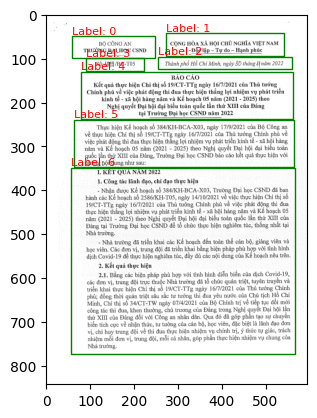

In [3]:
# Load the image
image_path = 'dataGNN/img_train_3/scan030_page_1.png'
image = cv2.imread(image_path)

# Load the bounding box coordinates from the YOLO format text file
with open('dataGNN/labels_3/scan030_page_1.txt', 'r') as file:
    lines = file.readlines()

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Process each line in the file
for line in lines:
    parts = line.strip().split()
    label = int(parts[0])
    x_center, y_center, width, height = map(float, parts[1:])
    
    # Convert YOLO coordinates to absolute coordinates
    img_h, img_w, _ = image.shape
    x = int((x_center - width/2) * img_w)
    y = int((y_center - height/2) * img_h)
    w = int(width * img_w)
    h = int(height * img_h)

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display label
    ax.text(x, y - 5, f'Label: {label}', color='r', fontsize=8)

# Show the plot
plt.show()

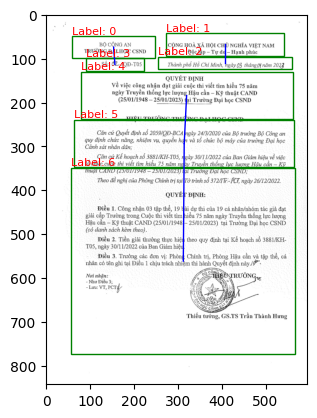

In [17]:
# Load the image
image_path = 'dataGNN/img_train_3/scan029_page_1.png'
image = cv2.imread(image_path)

# Load the bounding box coordinates from the YOLO format text file
with open('dataGNN/labels_3/scan030_page_1.txt', 'r') as file:
    lines = file.readlines()

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Create a graph
G = nx.Graph()

# Process each line in the file
for line in lines:
    parts = line.strip().split()
    label = int(parts[0])
    x_center, y_center, width, height = map(float, parts[1:])
    
    # Convert YOLO coordinates to absolute coordinates
    img_h, img_w, _ = image.shape
    x = int((x_center - width/2) * img_w)
    y = int((y_center - height/2) * img_h)
    w = int(width * img_w)
    h = int(height * img_h)

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display label
    ax.text(x, y - 5, f'Label: {label}', color='r', fontsize=8)

    # Add node to the graph
    G.add_node(label, pos=(x+w/2, y+h/2))

# Calculate distances and add edges to the graph
for source_label in G.nodes():
    min_distance = float('inf')
    nearest_label = None
    source_pos = G.nodes[source_label]['pos']

    for target_label in G.nodes():
        if source_label != target_label:
            target_pos = G.nodes[target_label]['pos']
            distance = ((source_pos[0] - target_pos[0])**2 + (source_pos[1] - target_pos[1])**2)**0.5

            if distance < min_distance:
                min_distance = distance
                nearest_label = target_label

    if nearest_label is not None:
        G.add_edge(source_label, nearest_label, weight=1/min_distance)


# Sort nodes based on their positions from top to bottom and left to right
# sorted_nodes = sorted(G.nodes(data=True), key=lambda x: (x[1]['pos'][1], x[1]['pos'][0]))

# # Add edges to the graph between adjacent nodes
# for i in range(len(sorted_nodes) - 1):
#     G.add_edge(sorted_nodes[i][0], sorted_nodes[i + 1][0])
# Draw bounding box edges
for edge in G.edges():
    source_label, target_label = edge
    source_pos = G.nodes[source_label]['pos']
    target_pos = G.nodes[target_label]['pos']
    ax.plot([source_pos[0], target_pos[0]], [source_pos[1], target_pos[1]], 'b-', lw=1)

# Show the plot
plt.show()

# Data-preprocessing
## Graph modeling

In [2]:
# Thư mục chứa hình ảnh và nhãn
image_folder = './dataGNN/img_train_3/'
label_folder = './dataGNN/labels_3/'

# Lấy danh sách các tệp tin hình ảnh trong thư mục
image_files = os.listdir(image_folder)

# Tạo một danh sách để lưu trữ dữ liệu đầu vào cho mỗi hình ảnh
all_data = []

# Lặp qua từng tệp tin hình ảnh
for image_file in image_files:
    # Đường dẫn đầy đủ đến hình ảnh và tệp tin nhãn tương ứng
    image_path = os.path.join(image_folder, image_file)
    label_path = os.path.join(label_folder, image_file.replace('.png', '.txt'))

    # Load hình ảnh
    image = cv2.imread(image_path)

    # Load bounding box coordinates from the YOLO format text file
    with open(label_path, 'r') as file:
        lines = file.readlines()

    # Create a graph
    G = nx.Graph()

    # Process each line in the file
    for line in lines:
        parts = line.strip().split()
        label = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Convert YOLO coordinates to absolute coordinates
        img_h, img_w, _ = image.shape
        x = int((x_center - width/2) * img_w)
        y = int((y_center - height/2) * img_h)
        w = int(width * img_w)
        h = int(height * img_h)

        # Add node to the graph
        G.add_node(label, pos=(x+w/2, y+h/2))

    # Calculate distances and add edges to the graph
    for source_label in G.nodes():
        min_distance = float('inf')
        nearest_label = None
        source_pos = G.nodes[source_label]['pos']

        for target_label in G.nodes():
            if source_label != target_label:
                target_pos = G.nodes[target_label]['pos']
                distance = ((source_pos[0] - target_pos[0])**2 + (source_pos[1] - target_pos[1])**2)**0.5

                if distance < min_distance:
                    min_distance = distance
                    nearest_label = target_label

        if nearest_label is not None:
            G.add_edge(source_label, nearest_label, weight=1/min_distance)

#     sorted_nodes = sorted(G.nodes(data=True), key=lambda x: (x[1]['pos'][1], x[1]['pos'][0]))

# # Add edges to the graph between adjacent nodes
#     for i in range(len(sorted_nodes) - 1):
#         G.add_edge(sorted_nodes[i][0], sorted_nodes[i + 1][0])

    # Convert the graph to PyTorch Geometric Data
    pos = torch.tensor([list(G.nodes[label]['pos']) for label in G.nodes()], dtype=torch.float)
    edges = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    data = Data(x=pos, edge_index=edges)

    # Append the data to the list
    all_data.append(data)

In [3]:
# Chia dữ liệu thành tập huấn luyện (90%) và tập kiểm thử (10%)
train_data, test_data = train_test_split(all_data, test_size=0.1, random_state=42)

# In kích thước của tập huấn luyện và tập kiểm thử
print(f'Train set size: {len(train_data)} samples')
print(f'Test set size: {len(test_data)} samples')

Train set size: 18 samples
Test set size: 3 samples


In [4]:
for data in train_data:
        labels = torch.arange(len(data.x))
        print(data)

Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 5])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 5])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 4])
Data(x=[7, 2], edge_index=[2, 5])
Data(x=[7, 2], edge_index=[2, 5])
Data(x=[7, 2], edge_index=[2, 5])


# Training

In [6]:
def train_model(model, optimizer, criterion, scheduler, train_data, test_data, num_epochs=300):
    train_losses = []  # To store training loss values for each epoch
    test_losses = []   # To store testing loss values for each epoch
    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        for data in train_data:
            optimizer.zero_grad()
            out = model(data)
            labels = torch.arange(len(data.x))
            #labels = torch.arange(len(data.x)) % 8
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Testing
        model.eval()
        total_test_loss = 0

        with torch.no_grad():
            for data in test_data:
                out = model(data)
                labels = torch.arange(len(data.x))
                loss = criterion(out, labels)
                total_test_loss += loss.item()

                preds = torch.argmax(out, dim=1)
                all_preds.extend(preds.tolist())
                all_labels.extend(labels.tolist())

        # Adjust learning rate based on the training loss
        scheduler.step(total_train_loss)

        # Print average training and testing loss for each epoch
        average_train_loss = total_train_loss / len(train_data)
        average_test_loss = total_test_loss / len(test_data)
        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss}, Test Loss: {average_test_loss}')

        # Save loss values for plotting later
        train_losses.append(average_train_loss)
        test_losses.append(average_test_loss)

    return train_losses, test_losses, all_labels, all_preds

def visualize_results(train_losses, test_losses):
    # Plot the training loss and testing loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    rp = classification_report(all_labels, all_preds)
    return accuracy,recall,precision,f1,rp

## GAT

Epoch 1, Train Loss: 92.54129367404514, Test Loss: 43.15269215901693
Epoch 2, Train Loss: 47.28944412867228, Test Loss: 28.295624415079754
Epoch 3, Train Loss: 27.282765176561142, Test Loss: 13.729291915893555
Epoch 4, Train Loss: 17.14946725633409, Test Loss: 5.637080669403076
Epoch 5, Train Loss: 5.3033523427115545, Test Loss: 3.0406405131022134
Epoch 6, Train Loss: 5.720820923646291, Test Loss: 2.023661414782206
Epoch 7, Train Loss: 4.914508693748051, Test Loss: 1.636320988337199
Epoch 8, Train Loss: 4.753904693656498, Test Loss: 1.5323009093602498
Epoch 9, Train Loss: 3.7130872507890067, Test Loss: 1.3187391360600789
Epoch 10, Train Loss: 3.0675868656900196, Test Loss: 1.888702154159546
Epoch 11, Train Loss: 4.8270593418015375, Test Loss: 1.3611901601155598
Epoch 12, Train Loss: 5.813689351081848, Test Loss: 1.342955509821574
Epoch 13, Train Loss: 3.4067106578085156, Test Loss: 1.325561801592509
Epoch 14, Train Loss: 4.172032747003767, Test Loss: 1.254401683807373
Epoch 15, Train L

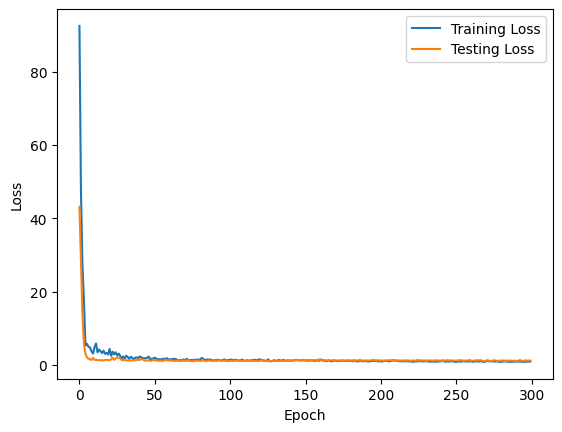

Final Loss on GAT model: 1.1340221762657166
0.46008980917485537
              precision    recall  f1-score   support

           0       0.41      0.14      0.21       900
           1       0.34      0.55      0.42       900
           2       0.36      0.41      0.38       900
           3       0.50      0.21      0.29       900
           4       0.13      0.19      0.15       900
           5       0.82      0.78      0.80       900
           6       0.94      0.99      0.96       900

    accuracy                           0.47      6300
   macro avg       0.50      0.47      0.46      6300
weighted avg       0.50      0.47      0.46      6300



In [7]:
# Define a GAT model_GAT
# class GATModel(nn.Module):
#     def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5, heads=1):
#         super(GATModel, self).__init__()
#         self.conv1 = GATConv(num_features, hidden_size, heads=heads, dropout=dropout_rate)
#         self.conv2 = GATConv(hidden_size * heads, num_classes, heads=1, concat=False, dropout=dropout_rate)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         x = self.conv2(x, edge_index)
#         return x

import torch.nn.functional as F

class GATModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5, heads=1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(num_features, hidden_size, heads=heads, dropout=dropout_rate)
        self.conv2 = GATConv(hidden_size * heads, hidden_size, heads=heads, dropout=dropout_rate)
        self.conv3 = GATConv(hidden_size * heads, num_classes, heads=1, concat=False, dropout=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x


# Initialize the GAT model_GAT, optimizer_GAT, and criterion_GAT
model_GAT = GATModel(num_features=2, hidden_size=16, num_classes=9, dropout_rate=0.05, heads=2)
optimizer_GAT = optim.Adam(model_GAT.parameters(), lr=0.001, weight_decay=1e-5)
criterion_GAT = nn.CrossEntropyLoss()

# Learning rate scheduler_GAT
scheduler_GAT = ReduceLROnPlateau(optimizer_GAT, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_GAT, test_losses_GAT, all_labels_GAT, all_preds_GAT = train_model(model_GAT, optimizer_GAT, criterion_GAT, scheduler_GAT, train_data, test_data)

# Visualize the training and testing results
visualize_results(train_losses_GAT, test_losses_GAT)
final_loss_GAT = test_losses_GAT[-1]
print(f'Final Loss on GAT model: {final_loss_GAT}')
accuracy_GAT, recall_GAT, prec_GAT, f1_GAT,rp = evaluate(all_labels_GAT, all_preds_GAT)
print(f1_GAT)
print(rp)

## GraphSAGE

Epoch 1, Train Loss: 30.436983797285293, Test Loss: 41.39269256591797
Epoch 2, Train Loss: 12.47280940744612, Test Loss: 22.79755401611328
Epoch 3, Train Loss: 6.450328694449531, Test Loss: 14.547759691874186
Epoch 4, Train Loss: 4.432538866996765, Test Loss: 10.390677452087402
Epoch 5, Train Loss: 3.225459936592314, Test Loss: 7.844618320465088
Epoch 6, Train Loss: 2.482510507106781, Test Loss: 5.997475783030192
Epoch 7, Train Loss: 1.8536765509181552, Test Loss: 4.277528762817383
Epoch 8, Train Loss: 1.4056607319249048, Test Loss: 2.9777115980784097
Epoch 9, Train Loss: 1.0283432006835938, Test Loss: 1.832728624343872
Epoch 10, Train Loss: 0.8439087553156747, Test Loss: 1.2387041052182515
Epoch 11, Train Loss: 0.6498426116175122, Test Loss: 0.7240506907304128
Epoch 12, Train Loss: 0.5691104580958685, Test Loss: 0.4885282814502716
Epoch 13, Train Loss: 0.501727271411154, Test Loss: 0.3892698486646016
Epoch 14, Train Loss: 0.4749554495016734, Test Loss: 0.43964547912279767
Epoch 15, Tr

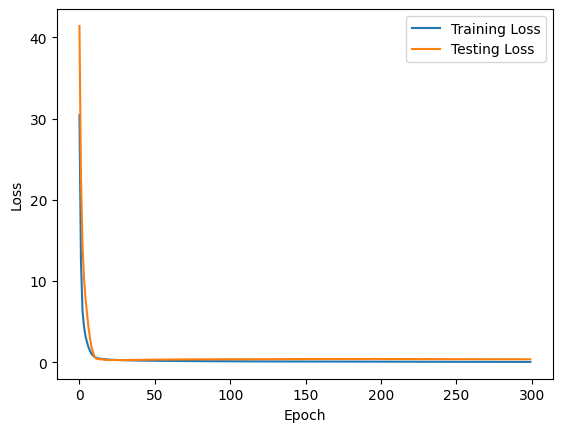

Final Loss on GSAGE model: 0.3637552860503395


In [17]:
from torch.nn import functional as F

# # Define the GraphSAGE model_GSAGE
# class GraphSAGEModel(nn.Module):
#     def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
#         super(GraphSAGEModel, self).__init__()
#         self.conv1 = SAGEConv(num_features, hidden_size)
#         self.conv2 = SAGEConv(hidden_size, num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         x = self.conv2(x, edge_index)
        
#         return x

class GraphSAGEModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_size)
        self.conv2 = SAGEConv(hidden_size, hidden_size)
        self.conv3 = SAGEConv(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

model_GSAGE = GraphSAGEModel(num_features=2, hidden_size=16, num_classes=9, dropout_rate=0.5)
optimizer_GSAGE = optim.Adam(model_GSAGE.parameters(), lr=0.001, weight_decay=1e-5)
criterion_GSAGE = nn.CrossEntropyLoss()

# Learning rate scheduler_GSAGE
scheduler_GSAGE = ReduceLROnPlateau(optimizer_GSAGE, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_GSAGE, test_losses_GSAGE, all_labels_GSAGE, all_preds_GSAGE = train_model(model_GSAGE, optimizer_GSAGE, criterion_GSAGE, scheduler_GSAGE, train_data, test_data)

# Visualize the training and testing results
visualize_results(train_losses_GSAGE, test_losses_GSAGE)
final_loss_GSAGE = test_losses_GSAGE[-1]
print(f'Final Loss on GSAGE model: {final_loss_GSAGE}')
accuracy_GSAGE, recall_GSAGE, prec_GSAGE, f1_GSAGE = evaluate(all_labels_GSAGE, all_preds_GSAGE)


## GCN

Epoch 1, Train Loss: 61.82179578145345, Test Loss: 42.470132191975914
Epoch 2, Train Loss: 36.51725313398573, Test Loss: 24.177743911743164
Epoch 3, Train Loss: 20.104698605007595, Test Loss: 15.46506150563558
Epoch 4, Train Loss: 13.134707397884792, Test Loss: 11.579032262166342
Epoch 5, Train Loss: 9.284940772586399, Test Loss: 7.6536933581034345
Epoch 6, Train Loss: 6.473683410220676, Test Loss: 5.478522618611653
Epoch 7, Train Loss: 4.538022001584371, Test Loss: 3.69321608543396
Epoch 8, Train Loss: 2.890556553999583, Test Loss: 2.453941901524862
Epoch 9, Train Loss: 1.9915944337844849, Test Loss: 2.2405234972635903
Epoch 10, Train Loss: 1.7450346615579393, Test Loss: 2.0129950443903604
Epoch 11, Train Loss: 1.5592042340172663, Test Loss: 1.8767790794372559
Epoch 12, Train Loss: 1.4242859019173517, Test Loss: 1.757554292678833
Epoch 13, Train Loss: 1.337961110803816, Test Loss: 1.6778624057769775
Epoch 14, Train Loss: 1.2832521431975894, Test Loss: 1.609700123469035
Epoch 15, Train

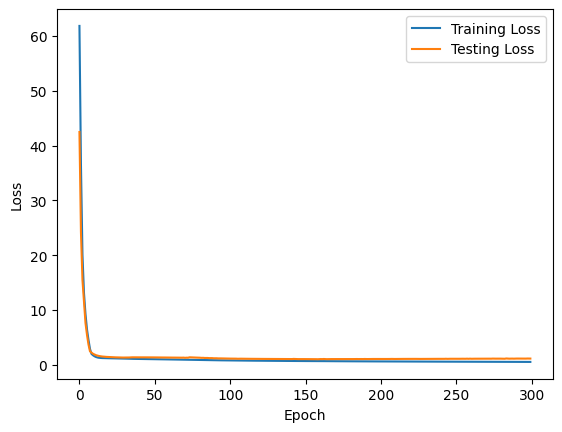

Final Loss on GCN model: 1.1413262883822124


c:\Users\ASUS\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from torch.nn import BatchNorm1d
# Define the Graph Convolutional Network (GCN) model_GCN
class GCNModel_GCN(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(GCNModel_GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Initialize the GCN model_GCN, optimizer_GCN, and criterion_GCN
model_GCN = GCNModel_GCN(num_features=2, hidden_size=16, num_classes=9, dropout_rate=0.05)
optimizer_GCN = optim.Adam(model_GCN.parameters(), lr=0.001, weight_decay=1e-5)
criterion_GCN = nn.CrossEntropyLoss()

# Learning rate scheduler_GCN
scheduler_GCN = ReduceLROnPlateau(optimizer_GCN, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_GCN, test_losses_GCN, all_labels_GCN, all_preds_GCN = train_model(model_GCN, optimizer_GCN, criterion_GCN, scheduler_GCN, train_data, test_data)

# Visualize the training and testing results
visualize_results(train_losses_GCN, test_losses_GCN)

final_loss_GCN = test_losses_GCN[-1]
print(f'Final Loss on GCN model: {final_loss_GCN}')
accuracy_GCN, recall_GCN, prec_GCN, f1_GCN = evaluate(all_labels_GCN, all_preds_GCN)

## PNA

Epoch 1, Train Loss: 2.318673219945696, Test Loss: 2.481748183568319
Epoch 2, Train Loss: 1.486801352765825, Test Loss: 1.7683430512746174
Epoch 3, Train Loss: 1.162903520796034, Test Loss: 1.1970025698343914
Epoch 4, Train Loss: 0.9909391105175018, Test Loss: 1.0496554772059123
Epoch 5, Train Loss: 0.8680551085207198, Test Loss: 0.8569144209225973
Epoch 6, Train Loss: 0.7651535007688735, Test Loss: 0.8377334674199423
Epoch 7, Train Loss: 0.6914481586880155, Test Loss: 0.8221477468808492
Epoch 8, Train Loss: 0.6443735990259383, Test Loss: 0.7578470905621847
Epoch 9, Train Loss: 0.6050964593887329, Test Loss: 0.7242292364438375
Epoch 10, Train Loss: 0.5722246865431467, Test Loss: 0.7012872894605001
Epoch 11, Train Loss: 0.5385270549191369, Test Loss: 0.6811326146125793
Epoch 12, Train Loss: 0.5121793581379784, Test Loss: 0.6688867211341858
Epoch 13, Train Loss: 0.4848749902513292, Test Loss: 0.6426654855410258
Epoch 14, Train Loss: 0.4617987357907825, Test Loss: 0.6196180780728658
Epoch

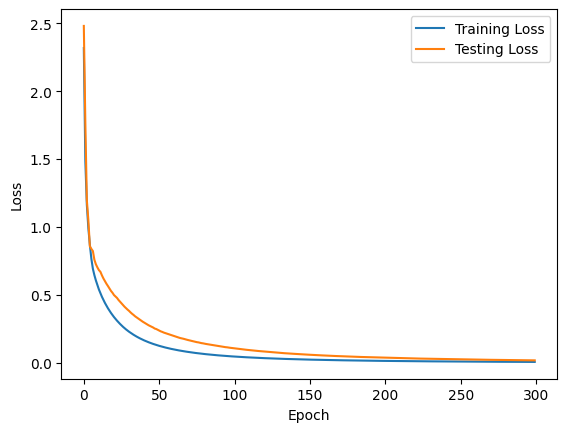

Final Loss on PNA model: 0.015883953931430977


c:\Users\ASUS\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# Define the PNAConv model
class PNAConvModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(PNAConvModel, self).__init__()

        # Make sure deg is a PyTorch tensor
        deg = torch.tensor(1.0)  # You may need to adjust the value based on your requirements

        # Make sure scalers is a list of strings
        scalers = ['identity', 'identity', 'identity']
        
        self.conv1 = PNAConv(in_channels=num_features, out_channels=hidden_size, heads=4, flow='source_to_target', aggregators=['mean', 'min', 'max'], scalers=scalers, deg=deg)
        self.conv2 = PNAConv(in_channels=hidden_size, out_channels=num_classes, heads=4, flow='target_to_source', aggregators=['mean', 'min', 'max'], scalers=scalers, deg=deg)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x
    
    
# Initialize the PNAConv model, optimizer_PNA, and criterion_PNA
model_PNA = PNAConvModel(num_features=2, hidden_size=16, num_classes=9, dropout_rate=0.05)
optimizer_PNA = optim.Adam(model_PNA.parameters(), lr=0.001, weight_decay=1e-5)
criterion_PNA = nn.CrossEntropyLoss()

# Learning rate scheduler_PNA
scheduler_PNA = ReduceLROnPlateau(optimizer_PNA, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

# Assuming you have train_data and test_data defined before
train_losses_PNA, test_losses_PNA, all_labels_PNA, all_preds_PNA = train_model(model_PNA, optimizer_PNA, criterion_PNA, scheduler_PNA, train_data, test_data)

# Visualize the training and testing results
visualize_results(train_losses_PNA, test_losses_PNA)

final_loss_PNA = test_losses_PNA[-1]
print(f'Final Loss on PNA model: {final_loss_PNA}')
accuracy_PNA, recall_PNA, prec_PNA, f1_PNA = evaluate(all_labels_PNA, all_preds_PNA)

## SGC

Epoch 1, Train Loss: 2.3749877081976996, Test Loss: 2.086628039677938
Epoch 2, Train Loss: 2.187685595618354, Test Loss: 1.9838939507802327
Epoch 3, Train Loss: 1.9444259736273024, Test Loss: 1.821048418680827
Epoch 4, Train Loss: 1.7982106142573886, Test Loss: 1.7357232968012493
Epoch 5, Train Loss: 1.674846159087287, Test Loss: 1.6831899086634319
Epoch 6, Train Loss: 1.591266651948293, Test Loss: 1.624937891960144
Epoch 7, Train Loss: 1.5334042244487338, Test Loss: 1.570183515548706
Epoch 8, Train Loss: 1.4182016783290439, Test Loss: 1.4897953271865845
Epoch 9, Train Loss: 1.3233195344607036, Test Loss: 1.4155136346817017
Epoch 10, Train Loss: 1.2296662396854825, Test Loss: 1.347187081972758
Epoch 11, Train Loss: 1.1272012955612607, Test Loss: 1.3027534484863281
Epoch 12, Train Loss: 1.0647282136811151, Test Loss: 1.2723044157028198
Epoch 13, Train Loss: 1.0109715991550021, Test Loss: 1.2034406264623005
Epoch 14, Train Loss: 0.9325551125738356, Test Loss: 1.1879772345225017
Epoch 15,

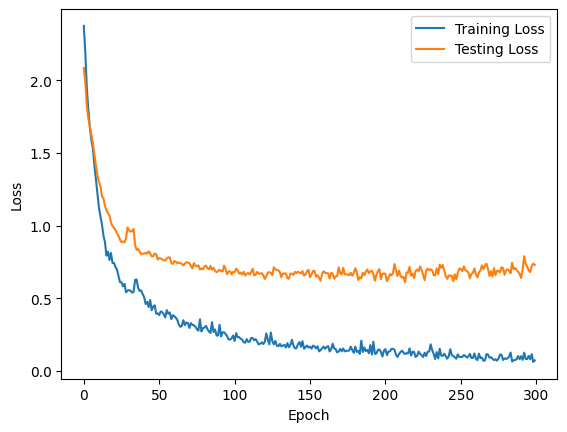

Final Loss on GAT model: 0.7306394179662069


In [36]:
# Define the SGConv model_SGC
# class SGConvModel(nn.Module):
#     def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
#         super(SGConvModel, self).__init__()
        
#         self.conv1 = SGConv(in_channels=num_features, out_channels=hidden_size, K=2)
#         self.conv2 = SGConv(in_channels=hidden_size, out_channels=num_classes, K=2)
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         x = self.dropout(x)
#         x = self.conv2(x, edge_index)
#         return x
    
import torch
import torch.nn as nn
from torch_geometric.nn import SGConv, global_mean_pool

class SGConvModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, dropout_rate=0.5):
        super(SGConvModel, self).__init__()
        
        self.conv1 = SGConv(in_channels=num_features, out_channels=hidden_size, K=2)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.conv2 = SGConv(in_channels=hidden_size, out_channels=num_classes, K=2)
        self.bn2 = nn.BatchNorm1d(num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)

        # Global pooling to obtain a graph-level representation

        return x

# Initialize the SGConv model, optimizer_SGC, and criterion_SGC
model_SGC = SGConvModel(num_features=2, hidden_size=16, num_classes=9, dropout_rate=0.05)
optimizer_SGC = optim.Adam(model_SGC.parameters(), lr=0.001, weight_decay=1e-5)
criterion_SGC = nn.CrossEntropyLoss()

# Learning rate scheduler_SGC
scheduler_SGC = ReduceLROnPlateau(optimizer_SGC, mode='min', factor=0.5, patience=1000, min_lr=1e-6)

train_losses_SGC, test_losses_SGC, all_labels_SGC, all_preds_SGC = train_model(model_SGC, optimizer_SGC, criterion_SGC, scheduler_SGC, train_data, test_data)

# Visualize the training and testing results
visualize_results(train_losses_SGC, test_losses_SGC)

final_loss_SGC = test_losses_SGC[-1]
print(f'Final Loss on GAT model: {final_loss_SGC}')
accuracy_SGC, recall_SGC, prec_SGC, f1_SGC = evaluate(all_labels_SGC, all_preds_SGC)

## Visualize

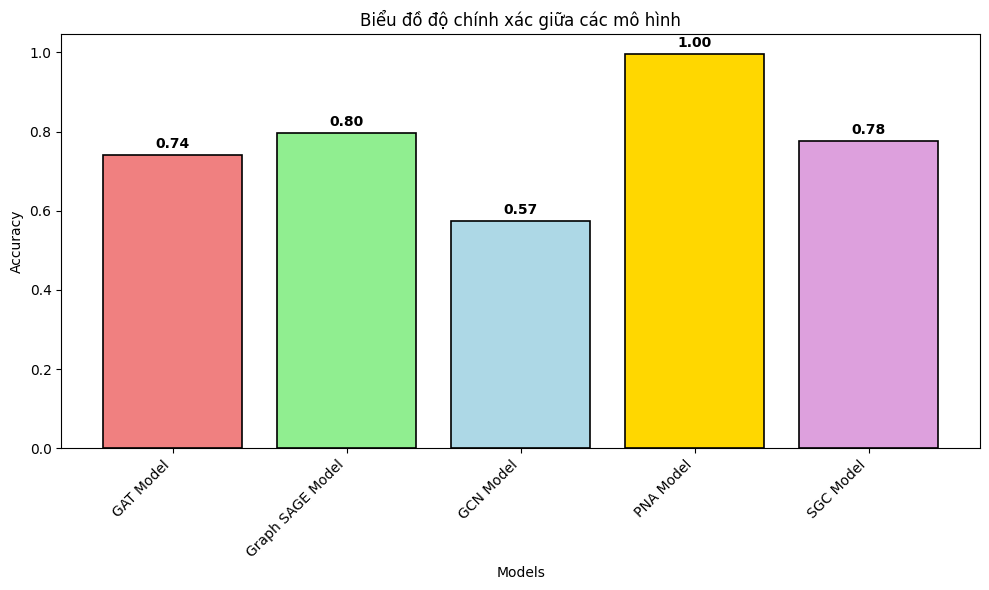

In [53]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNA Model', 'SGC Model']
values = [accuracy_GAT, accuracy_GSAGE, accuracy_GCN, accuracy_PNA, accuracy_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ độ chính xác giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

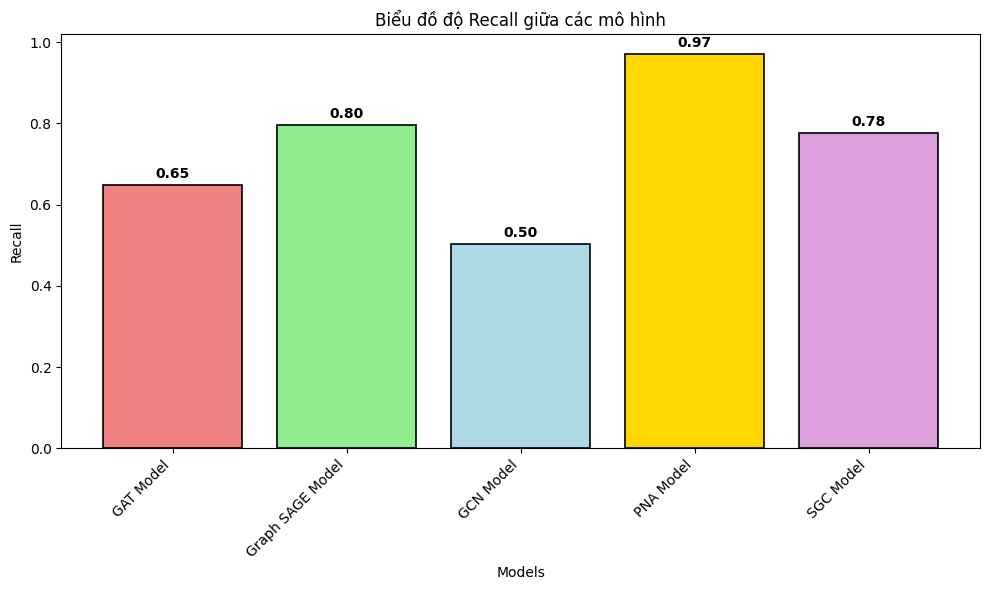

In [40]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNA Model', 'SGC Model']
values = [recall_GAT, recall_GSAGE, recall_GCN, recall_PNA, recall_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ độ Recall giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Recall')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

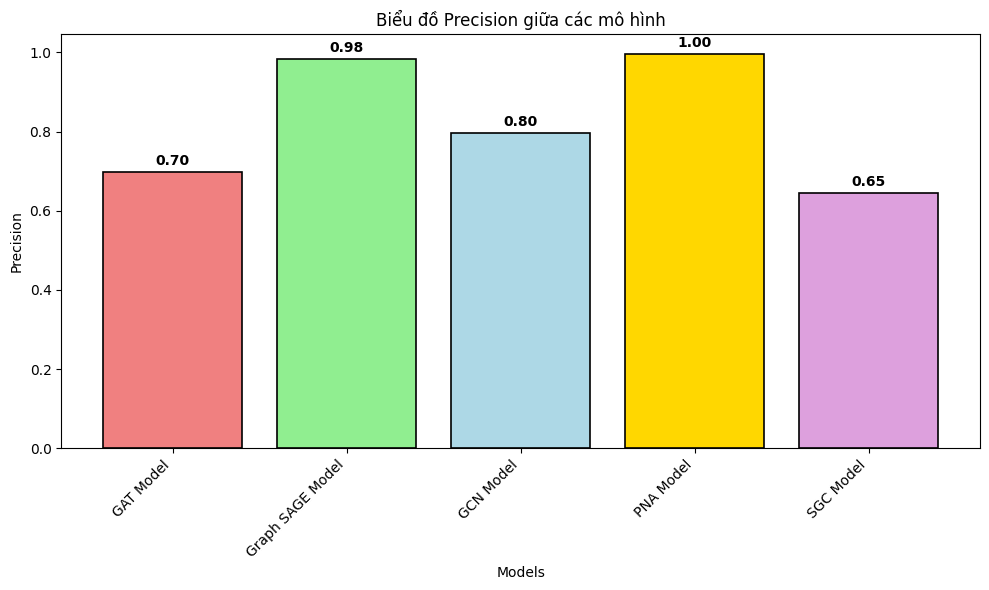

In [77]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNA Model', 'SGC Model']
values = [prec_GAT, prec_GSAGE, prec_GCN, prec_PNA, prec_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ Precision giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Precision')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

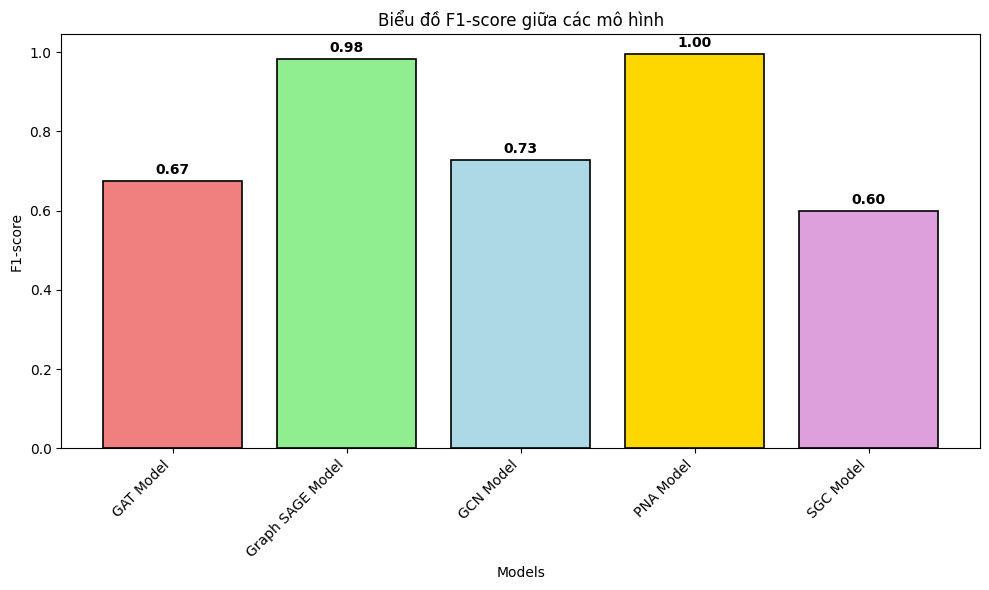

In [78]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNA Model', 'SGC Model']
values = [f1_GAT, f1_GSAGE, f1_GCN, f1_PNA, f1_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ F1-score giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('F1-score')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

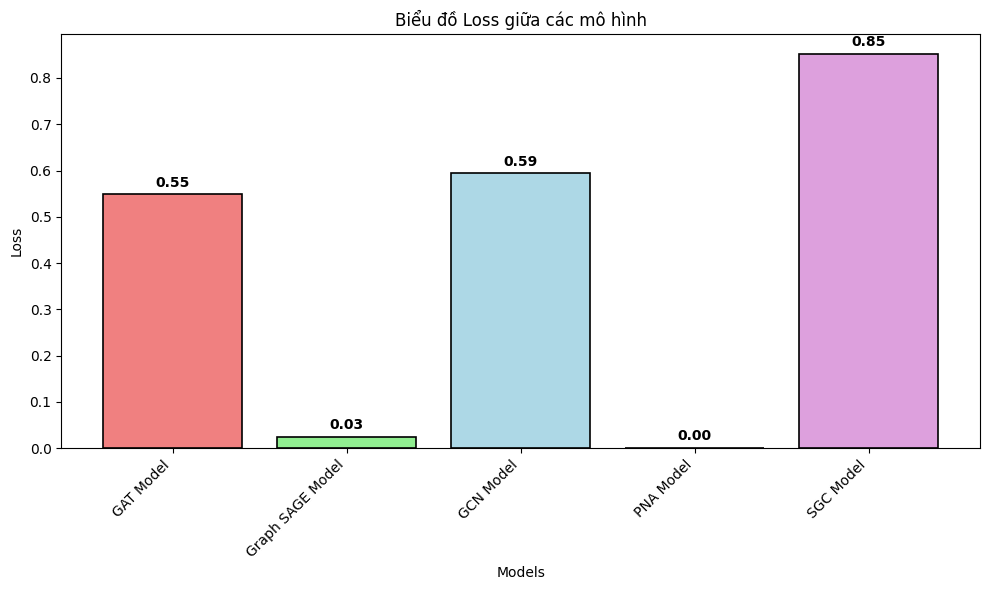

In [79]:
# Dữ liệu
categories = ['GAT Model', 'Graph SAGE Model', 'GCN Model', 'PNA Model', 'SGC Model']
values = [final_loss_GAT, final_loss_GSAGE, final_loss_GCN, final_loss_PNA, final_loss_SGC]

# Danh sách màu sắc cho từng cột
colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold', 'plum']

# Tăng kích thước của biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ cột với màu sắc tương ứng và thêm viền
bars = plt.bar(categories, values, color=colors, edgecolor='black', linewidth=1.2)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ Loss giữa các mô hình')
plt.xlabel('Models')
plt.ylabel('Loss')

# Đặt hình dạng của biểu đồ cột thành 'tick' để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# In giá trị lên đầu mỗi cột với khoảng cách cao hơn
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()  # Giữ cho biểu đồ sạch sẽ hơn
plt.show()

# Test

In [9]:
def create_test_data(image_path, label_path):
    # Load hình ảnh
    image = cv2.imread(image_path)

    # Load bounding box coordinates from the YOLO format text file
    with open(label_path, 'r') as file:
        lines = file.readlines()

    # Tạo một đối tượng Data cho PyTorch Geometric
    G = nx.Graph()

    # Process từng bounding box trong tệp tin
    for line in lines:
        parts = line.strip().split()
        x_center, y_center, width, height = map(float, parts)

        # Chuyển đổi tọa độ YOLO sang tọa độ tuyệt đối
        img_h, img_w, _ = image.shape
        x = int((x_center - width/2) * img_w)
        y = int((y_center - height/2) * img_h)
        w = int(width * img_w)
        h = int(height * img_h)

        # Thêm đỉnh vào đồ thị với ID là tọa độ tuyệt đối
        G.add_node((x+w/2, y+h/2))

    # Tính khoảng cách và thêm cạnh vào đồ thị
    for source_pos in G.nodes():
        min_distance = float('inf')
        nearest_pos = None

        for target_pos in G.nodes():
            if source_pos != target_pos:
                distance = ((source_pos[0] - target_pos[0])**2 + (source_pos[1] - target_pos[1])**2)**0.5

                if distance < min_distance:
                    min_distance = distance
                    nearest_pos = target_pos

        if nearest_pos is not None:
            G.add_edge(source_pos, nearest_pos, weight=1/min_distance)

    # Create a mapping between old and new node indices
    mapping = {node: i for i, node in enumerate(G.nodes())}

    # Chuyển đồ thị thành đối tượng Data của PyTorch Geometric
    pos = torch.tensor([list(pos) for pos in G.nodes()], dtype=torch.float)
    edges = torch.tensor([[mapping[edge[0]], mapping[edge[1]]] for edge in G.edges], dtype=torch.long).t().contiguous()
    labels = torch.arange(len(G.nodes()))  # Add node labels
    data = Data(x=pos, edge_index=edges, y=labels)

    return data, image

def draw_predictions(image, label_path, model, save_path='./predicted_crops/'):
    # Create the save_path directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Dự đoán với mô hình
    with torch.no_grad():
        out = model(data)
        predicted_labels = torch.argmax(out, dim=1)

    # Lấy tọa độ bounding box từ tệp tin YOLO
    with open(label_path, 'r') as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        parts = line.strip().split()
        x_center, y_center, width, height = map(float, parts)

        # Chuyển đổi tọa độ YOLO sang tọa độ tuyệt đối
        img_h, img_w, _ = image.shape
        x = int((x_center - width/2) * img_w)
        y = int((y_center - height/2) * img_h)
        w = int(width * img_w)
        h = int(height * img_h)

        # Get the predicted label for the corresponding node
        predicted_label = predicted_labels[i].item()

        # Vẽ bounding box và nhãn dự đoán lên hình ảnh
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)
        label_text = f'Predicted Label: {predicted_label}'
        cv2.putText(image, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        # Crop the image based on the bounding box
        cropped_image = image[y:y+h, x:x+w]

        # Save the cropped image with the predicted label as the filename
        save_filename = os.path.join(save_path, f'{predicted_label}.png')
        cv2.imwrite(save_filename, cropped_image)

    # Hiển thị và lưu hình ảnh gốc với bounding box và nhãn dự đoán
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

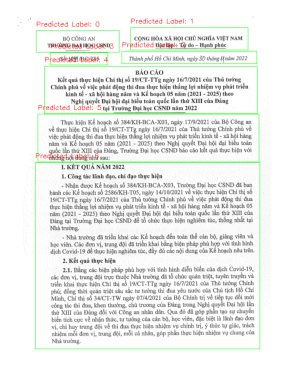

In [52]:
# Đường dẫn đến hình ảnh và tệp tin bounding box của hình ảnh kiểm thử
test_image_path = 'dataGNN/test/img/scan030_page_1.png'
test_label_path = 'dataGNN/test/lbls/scan030_page_1.txt'

# Tạo dữ liệu và hình ảnh từ hình ảnh và tệp tin bounding box
data, test_image = create_test_data(test_image_path, test_label_path)

# Vẽ nhãn dự đoán, bounding box, cắt và lưu ảnh
draw_predictions(test_image, test_label_path, model_PNA)

In [3]:
def zoom_images(input_folder, output_folder, zoom_factor=2):
    # Tạo thư mục đầu ra nếu nó không tồn tại
    os.makedirs(output_folder, exist_ok=True)

    # Lặp qua tất cả các tệp tin hình ảnh trong thư mục đầu vào
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
            input_path = os.path.join(input_folder, filename)

            # Đọc ảnh từ tệp tin
            image = cv2.imread(input_path)

            # Kiểm tra xem ảnh có hợp lệ hay không
            if image is not None:
                # Lấy kích thước ban đầu của ảnh
                original_height, original_width = image.shape[:2]

                # Tính kích thước mới sau khi zoom lên 2x
                zoomed_width = int(original_width * zoom_factor)
                zoomed_height = int(original_height * zoom_factor)

                # Thực hiện zoom ảnh
                zoomed_image = cv2.resize(image, (zoomed_width, zoomed_height))

                # Lưu ảnh đã zoom vào thư mục đầu ra với cùng tên file
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, zoomed_image)

input_folder = 'predicted_crops'
output_folder = 'predicted_crops_zoom'

zoom_images(input_folder, output_folder)


# OCR

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.vietocr.tool.predictor import Predictor
from vietocr.vietocr.tool.config import Cfg

from PaddleOCR import PaddleOCR, draw_ocr

In [5]:
FONT = './PaddleOCR/doc/fonts/latin.ttf'
def predict(recognitor, detector, img_path, save_path, padding=4, dpi=100):
    # Load image
    img = cv2.imread(img_path)

    # Text detection
    result = detector.ocr(img_path, cls=False, det=True, rec=False)
    result = result[:][:][0]

    # Filter Boxes
    boxes = []
    for line in result:
        boxes.append([[int(line[0][0]), int(line[0][1])], [int(line[2][0]), int(line[2][1])]])
    boxes = boxes[::-1]

    # Add padding to boxes
    padding = 4
    for box in boxes:
        box[0][0] = box[0][0] - padding
        box[0][1] = box[0][1] - padding
        box[1][0] = box[1][0] + padding
        box[1][1] = box[1][1] + padding

    # Text recognizion
    texts = []
    for box in boxes:
        cropped_image = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        try:
            cropped_image = Image.fromarray(cropped_image)
        except:
            continue

        rec_result = recognitor.predict(cropped_image)

        text = rec_result#[0]

        texts.append(text)
        # print(text)

    # Convert boxes to draw
    def get_rectangle_points(x1, y1, x2, y2):
        x_tl = x1
        y_tl = y2
        x_br = x2
        y_br = y1
        return [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    _boxes = [get_rectangle_points(boxe[0][0], boxe[0][1], boxe[1][0], boxe[1][1]) for boxe in boxes]

    # Draw boxes and texts
    img = draw_ocr(img, _boxes, texts, scores=None, font_path=FONT)


    # Save image
    img_name = img_path.split('/')[-1]
    cv2.imwrite(os.path.join(save_path, img_name), img)

    # Display image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    height, width, depth = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray')

    plt.show()

    return boxes, texts

def display_image_in_actual_size(img_path, dpi=200):
  im_data = cv2.imread(img_path)

  height, width, depth = im_data.shape

  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure of the right size with one axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc.
  ax.axis('off')

  # Display the image.
  ax.imshow(im_data, cmap='gray')

  plt.show()

In [6]:
# Config of PaddleOCR
detector = PaddleOCR(use_angle_cls=False, lang="vi", use_gpu=False)

[2023/12/21 16:09:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ASUS/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ASUS/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

In [7]:
# Configure of VietOCR
config = Cfg.load_config_from_name('vgg_transformer')
# config = Cfg.load_config_from_file('vietocr/config.yml')
# config['weights'] = '/Users/bmd1905/Desktop/pretrain_ocr/vi00_vi01_transformer.pth'

config['cnn']['pretrained'] = True
config['predictor']['beamsearch'] = True
config['device'] = 'cpu' # mps

recognitor = Predictor(config)

18533it [00:18, 1024.23it/s]


### ocr text

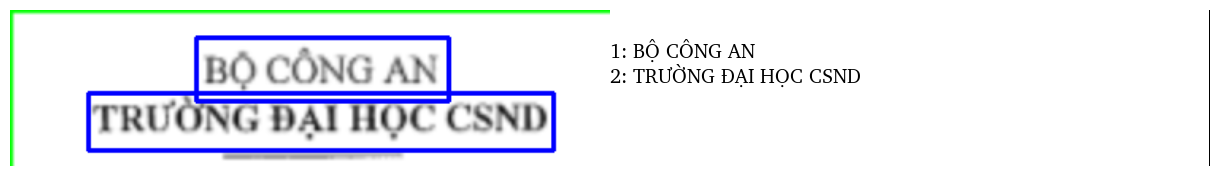

1. Nơi phát hành văn bản: BỘ CÔNG AN TRƯỜNG ĐẠI HỌC CSND


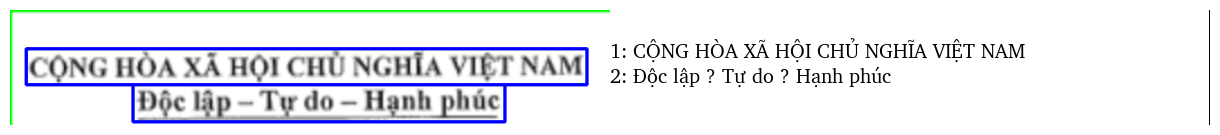

2. Ngày phát hành văn bản: CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM Độc lập ? Tự do ? Hạnh phúc


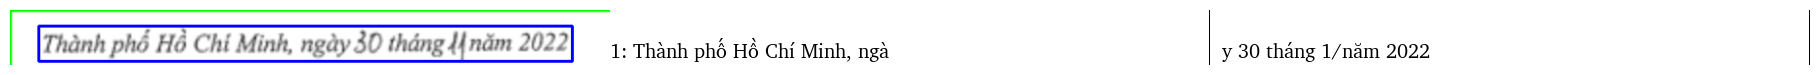

3. Số văn bản: Thành phố Hồ Chí Minh, ngày 30 tháng 1/năm 2022


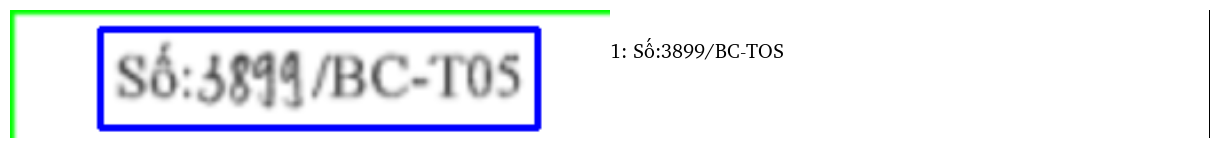

4. Tên văn bản: Số:3899/BC-TOS


In [11]:
import os

# Đường dẫn đến thư mục chứa ảnh đầu vào
input_folder = 'predicted_crops_zoom'

# Đường dẫn đến thư mục lưu kết quả đầu ra
output_folder = 'output'

# Lặp qua tất cả các tệp trong thư mục đầu vào
for filename in os.listdir(input_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        # Thực hiện nhận diện và lưu kết quả
        if filename == '0.png':
            boxes0, texts0 = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)
            result_str0 = ' '.join(texts0)
            print('1. Nơi phát hành văn bản: '+ result_str0)
        elif filename == '1.png':
            boxes1, texts1 = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)
            result_str1 = ' '.join(texts1)
            print('2. Ngày phát hành văn bản: '+ result_str1)
        if filename == '2.png':
            boxes2, texts2 = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)
            result_str2 = ' '.join(texts2)
            print('3. Số văn bản: '+ result_str2)
        if filename == '3.png':
            boxes3, texts3 = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)
            result_str3 = ' '.join(texts3)
            print('4. Tên văn bản: '+ result_str3)
            